In [141]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import rtree
import shapely.wkb
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point, MultiPolygon
from matplotlib import pyplot as plt
import LMIPy

In [375]:
ds = LMIPy.Layer('1a1d4f61-f1b3-4c1a-bfb5-9d0444ecdd56', server='https://staging-api.globalforestwatch.org')

In [376]:
ds

Layer 1a1d4f61-f1b3-4c1a-bfb5-9d0444ecdd56

In [377]:
ds.query("SELECT * FROM data").head()

,cartodb_id,label,the_geom,the_geom_webmercator,water_risk
0,0,Extremely High (>80%),0106000020E61000000100000001030000000100000005...,0106000020110F00000100000001030000000100000005...,4
1,89,Low - Medium (10-20%),0106000020E61000000100000001030000000100000009...,0106000020110F00000100000001030000000100000009...,1
2,112,High (40-80%),0106000020E61000000100000001030000000100000018...,0106000020110F00000100000001030000000100000018...,3
3,115,Arid and Low Water Use,0106000020E61000000100000001030000000100000004...,0106000020110F00000100000001030000000100000004...,-1
4,120,Arid and Low Water Use,0106000020E61000000100000001030000000100000004...,0106000020110F00000100000001030000000100000004...,-1


In [378]:
ds.map(lat=-3.65, lon=40.42, zoom=5)

### Read data

**Baseline Water Stress**

In [55]:
query =(" SELECT s.aq30_id, s.gid_1, bws_raw, bws_score, bws_cat,  bws_label, r.the_geom " 
        " FROM water_risk_indicators_annual_all s "
        " LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id "
        " WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999'and s.gid_1 like any (array['ESP%', 'PRT%'])")

account = 'wri-rw'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

bws = gpd.GeoDataFrame(data.get("rows"))
# Change geometry from WKB to WKT format
bws['geometry'] = bws.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
bws.drop(columns='the_geom', inplace=True)
bws.crs = {'init': 'epsg:4326'}
bws = bws.to_crs({'init': 'epsg:4326'})
bws.head(1)

,aq30_id,bws_cat,bws_label,bws_raw,bws_score,gid_1,geometry
0,17690,0,Low,0.021467,0.0,ESP.11_1,(POLYGON ((-5.99166666658337 39.83749999962531...


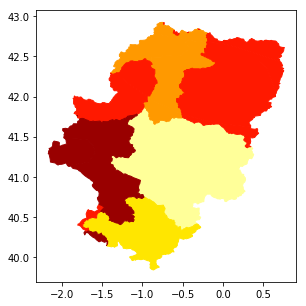

In [151]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')

for i in range(len(cat)):
    bws[(bws['gid_1'] == 'ESP.2_1') & (bws['bws_cat'] == cat[i])].plot(ax=ax, color=colors[i], edgecolor=colors[i])

**[MapSPAM](http://mapspam.info/data/) 2010 data**

In [66]:
query =(" SELECT aq30_id, cell5m, iso, crop, area, unit_area, the_geom FROM crops_baseline "
        " WHERE iso = 'ESP' and crop in ('wheat', 'maize', 'chickpea','lentil', 'potato') "
        " and irrigation = 'irrigated'")

account = 'wri-rw'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

crops = gpd.GeoDataFrame(data.get("rows"))
# Change geometry from WKB to WKT format
crops['geometry'] = crops.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
crops.drop(columns='the_geom', inplace=True)
crops.crs = {'init': 'epsg:4326'}
crops = crops.to_crs({'init': 'epsg:4326'})
crops.head(1)

,aq30_id,area,cell5m,crop,iso,unit_area,geometry
0,17804,13.8,2421266,potato,ESP,ha,(POLYGON ((-7.833333334021973 43.2499999994670...


**Merge datasets**

In [67]:
crops_bws = pd.merge(left=crops, right=bws.drop(columns='geometry'), how='left', on='aq30_id')
crops_bws.head(1)

,aq30_id,area,cell5m,crop,iso,unit_area,geometry,bws_cat,bws_label,bws_raw,bws_score,gid_1
0,17804,13.8,2421266,potato,ESP,ha,(POLYGON ((-7.833333334021973 43.2499999994670...,2.0,Medium - High,0.21747,2.120818,ESP.12_1


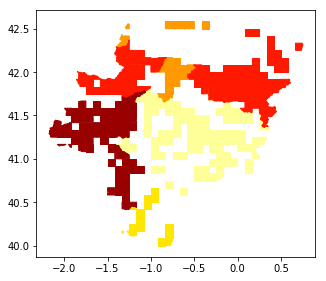

In [150]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(crops_bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')

for i in range(len(cat)):
    crops_bws[(crops_bws['gid_1'] == 'ESP.2_1') & (crops_bws['bws_cat'] == cat[i]) & (crops_bws['crop'] == 'maize')].plot(ax=ax, color=colors[i], edgecolor=colors[i])

## Calculator
**Exact Farm Location**

In [152]:
points = gpd.GeoDataFrame(columns=['geometry'], data= [Point(-1.15,41.75), Point(-1.15,41.75).buffer(1)])

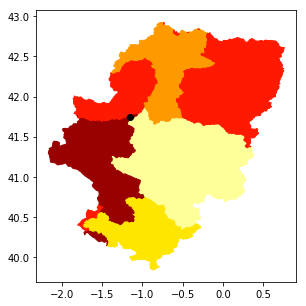

In [153]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')

for i in range(len(cat)):
    bws[(bws['gid_1'] == 'ESP.2_1') & (bws['bws_cat'] == cat[i])].plot(ax=ax, color=colors[i], edgecolor=colors[i])
points.iloc[:1].plot(ax=ax, color='k')

In [177]:
point = points.geometry.iloc[0]

# precise match
precise_match= bws[bws.intersects(point)]
precise_match

,aq30_id,bws_cat,bws_label,bws_raw,bws_score,gid_1,geometry
375,15161,4,Extremely High,0.898047,4.166791,ESP.2_1,(POLYGON ((-1.070833333491493 40.9750000000499...


**Point + Radius**

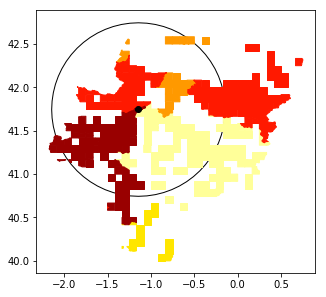

In [154]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(crops_bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')


points.iloc[1:2].plot(ax=ax, color='w', edgecolor='k')
for i in range(len(cat)):
    crops_bws[(crops_bws['gid_1'] == 'ESP.2_1') & (crops_bws['bws_cat'] == cat[i]) & (crops_bws['crop'] == 'maize')].plot(ax=ax, color=colors[i], edgecolor=colors[i])
    
points.iloc[:1].plot(ax=ax, color='k')

In [368]:
gdf = crops_bws[(crops_bws['gid_1'] == 'ESP.2_1') & (crops_bws['crop'] == 'maize')].copy()
area = points.geometry.iloc[1]

# precise match
precise_match= gdf[gdf.intersects(area)]
precise_match.head()

,aq30_id,area,cell5m,crop,iso,unit_area,geometry,bws_cat,bws_label,bws_raw,bws_score,gid_1
26,15157,0.0,2507750,maize,ESP,ha,(POLYGON ((-0.8333332158548216 41.666666666140...,2.0,Medium - High,0.378996,2.922183,ESP.2_1
98,15155,474.8,2490471,maize,ESP,ha,(POLYGON ((-0.7500000007170229 41.916666666139...,2.0,Medium - High,0.378996,2.922183,ESP.2_1
147,15161,0.2,2529338,maize,ESP,ha,(POLYGON ((-1.771963715195224 41.1666666661420...,4.0,Extremely High,0.898047,4.166791,ESP.2_1
1126,15175,61.5,2460224,maize,ESP,ha,(POLYGON ((-1.286801737504819 42.4999999994701...,2.0,Medium - High,0.310031,2.632411,ESP.2_1
1129,15175,10.8,2460230,maize,ESP,ha,(POLYGON ((-0.7500000007170229 42.508333333483...,2.0,Medium - High,0.310031,2.632411,ESP.2_1


/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


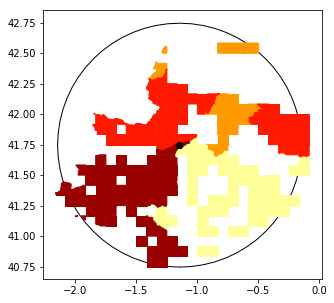

In [369]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(crops_bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')


points.iloc[1:2].plot(ax=ax, color='w', edgecolor='k')
for i in range(len(cat)):
    precise_match[precise_match['bws_cat'] == cat[i]].plot(ax=ax, color=colors[i], edgecolor=colors[i])
    
points.iloc[:1].plot(ax=ax, color='k')

In [372]:
print('Avg BWS:', np.sum(np.array(precise_match['bws_score'])*np.array(precise_match['area']))/np.sum(precise_match['area']))

Avg BWS: 2.933084655554206


In [373]:
gdf = crops_bws[(crops_bws['gid_1'] == 'ESP.2_1') & (crops_bws['crop'] == 'maize')].copy()
area = points.geometry.iloc[1]

# precise match
precise_match= gdf[gdf.intersects(area)]
precise_match.head()
# intersection between the basin and the area
intersection = precise_match.intersection(area)
precise_match['geometry_new'] = list(intersection)

# Percentage of the crop cell intersecting with the area 
def f(*x):
    return x[0].area/x[1].area
precise_match['percentage'] = precise_match[['geometry_new', 'geometry']].apply(lambda x: f(*x), axis=1).round(2)

# Multiply the area with the percentage
def f(*x):
    return x[0]*x[1]
precise_match['area'] = precise_match[['area','percentage']].apply(lambda x: f(*x), axis=1).round(1)


geoms = []
for g in precise_match.geometry_new:
    geoms.append(g)
    
a = list(precise_match.columns)
a.remove('geometry')
a.remove('geometry_new')

gdf = gpd.GeoDataFrame(precise_match[a], geometry=geoms)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


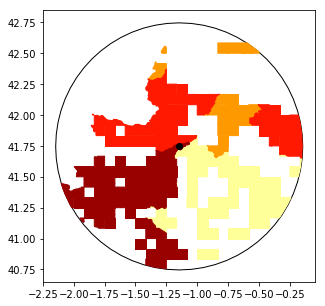

In [359]:
colors = ['#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cat = np.array(crops_bws['bws_cat'].unique())
cat = np.sort(cat[~np.isnan(cat)])

fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')


points.iloc[1:2].plot(ax=ax, color='w', edgecolor='k')
for i in range(len(cat)):
    gdf[gdf['bws_cat'] == cat[i]].plot(ax=ax, color=colors[i], edgecolor=colors[i])
    
points.iloc[:1].plot(ax=ax, color='k')

In [360]:
gdf.head()

,aq30_id,area,cell5m,crop,iso,unit_area,bws_cat,bws_label,bws_raw,bws_score,gid_1,percentage,geometry
26,15157,0.0,2507750,maize,ESP,ha,2.0,Medium - High,0.378996,2.922183,ESP.2_1,1.0,POLYGON ((-0.8333332158548216 41.6666666661400...
98,15155,474.8,2490471,maize,ESP,ha,2.0,Medium - High,0.378996,2.922183,ESP.2_1,1.0,POLYGON ((-0.7500000007170229 41.9166666661390...
147,15161,0.2,2529338,maize,ESP,ha,4.0,Extremely High,0.898047,4.166791,ESP.2_1,1.0,POLYGON ((-1.771963715195224 41.16666666614208...
1126,15175,61.5,2460224,maize,ESP,ha,2.0,Medium - High,0.310031,2.632411,ESP.2_1,1.0,POLYGON ((-1.286801737504819 42.49999999947011...
1129,15175,10.8,2460230,maize,ESP,ha,2.0,Medium - High,0.310031,2.632411,ESP.2_1,1.0,POLYGON ((-0.7500000007170229 42.5083333334838...


In [374]:
print('Avg BWS:', np.sum(np.array(gdf['bws_score'])*np.array(gdf['area']))/np.sum(gdf['area']))

Avg BWS: 2.921035738056926
